In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras


print(tf.__version__)
print(sys.version_info)

for module in mpl,np,pd,sklearn,tf,keras:
    print(module.__name__,module.__version__)

2.0.0
sys.version_info(major=3, minor=7, micro=7, releaselevel='final', serial=0)
matplotlib 3.2.2
numpy 1.18.5
pandas 1.0.5
sklearn 0.23.1
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all,y_train_all),(x_test,y_test) = fashion_mnist.load_data()
x_valid,x_train =  x_train_all[:5000],x_train_all[5000:]
y_valid,y_train =  y_train_all[:5000],y_train_all[5000:]

In [3]:
# 对数据做标准化(归一化)
# x = (x - u)/std (u:均值,std:方差)

from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()

# 需要一个二维矩阵 x_train是三维的，要转成二维矩阵，再转成三维
# [None,28,28] ---> [None,784]
x_train_sacled = scalar.fit_transform(
x_train.astype(np.float32).reshape(-1,1)
).reshape(-1,28,28)

x_valid_scaled = scalar.transform(x_valid.astype(np.float32).reshape(-1,1)).reshape(-1,28,28)

x_test_scaled = scalar.transform(x_test.astype(np.float32).reshape(-1,1)).reshape(-1,28,28)

In [4]:
# 构建深度学习网络

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))

for _ in range(20):
    model.add(keras.layers.Dense(100,activation="selu"))
  
# ※※※※※※※添加dropout※※※※※※※※
# 不是每层都添加dropout,一般在最后几层添加
model.add(keras.layers.AlphaDropout(rate=0.5))
# model.add(keras.layers.Dropout(rate=0.5))
"""
AlphaDropout与Dropout

AlphaDropout：
    1、均值和方差不变
    2、归一化性质也不变，可以批归一化和selu搭配使用，不会导致分布发生变化
一般都使用AlphaDropout与Dropout

"""
# ※※※※※※※添加dropout※※※※※※※※
model.add(keras.layers.Dense(10,activation="softmax"))

#  计算交叉熵损失
# reasone for sparse: y是一个单纯的数字(index),要变成one_hot编码
# 如果y已经是一个向量了就用categorical_crossentropy
# loss：损失函数 交叉熵损失
# optmizer：优化器 sgd 越来越小
# metrics:验证指标
model.compile(loss="sparse_categorical_crossentropy",optmizer = "sgd",metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               1

In [5]:
# Tensorboard,earlystopping,ModelCheckpoint
logdir=os.path.join('dnn-selu-dropout-callbacks')

if not os.path.exists(logdir):
    os.mkdir(logdir)

outout_model_file = os.path.join(logdir,"fashion_mnist_model.h5")

callbacks = [
    keras.callbacks.TensorBoard(log_dir=logdir),
    keras.callbacks.ModelCheckpoint(outout_model_file,save_best_only=True),
    tf.keras.callbacks.EarlyStopping(min_delta=1e-3, patience=5)
]

history = model.fit(x_train_sacled,y_train,epochs=10,validation_data=(x_valid_scaled,y_valid),callbacks=callbacks)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 26s 468us/sample - loss: 0.9462 - accuracy: 0.6524 - val_loss: 0.9552 - val_accuracy: 0.7392
Epoch 2/10
55000/55000 [==============================] - 21s 385us/sample - loss: 0.6815 - accuracy: 0.7581 - val_loss: 0.9413 - val_accuracy: 0.7808
Epoch 3/10
55000/55000 [==============================] - 21s 382us/sample - loss: 0.6014 - accuracy: 0.7998 - val_loss: 0.8010 - val_accuracy: 0.8400
Epoch 4/10
55000/55000 [==============================] - 22s 391us/sample - loss: 0.6564 - accuracy: 0.8227 - val_loss: 0.7386 - val_accuracy: 0.8530
Epoch 5/10
55000/55000 [==============================] - 21s 388us/sample - loss: 0.5647 - accuracy: 0.8323 - val_loss: 0.9460 - val_accuracy: 0.8480
Epoch 6/10
55000/55000 [==============================] - 21s 381us/sample - loss: 5.5986 - accuracy: 0.8415 - val_loss: 0.6883 - val_accuracy: 0.8616
Epoch 7/10
55000/55000 [=====================

In [16]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,6)
    plt.show()

In [17]:
# 训练初期曲线没什么变化的原因
# 1.参数众多，，训练不充分
# 2.梯度消失->链式法则->复合函数

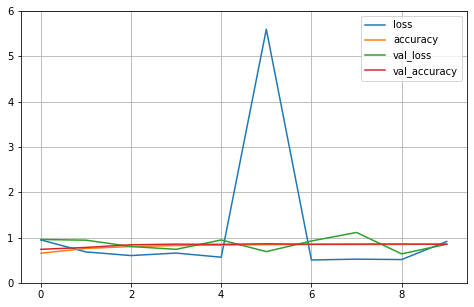

In [18]:
plot_learning_curves(history)

In [9]:
model.evaluate(x_test_scaled,y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.8462907100915908, 0.8421]